<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li>

# Проект для «Викишоп» (с BERT)

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75.

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели.
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [2]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [3]:
%%capture
!pip install transformers
!pip install swifter
!pip install wordcloud

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# очистка текста и лемматизация
import re
import spacy

# удаление стоп-слов
import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    RandomizedSearchCV,
    GridSearchCV
)

from sklearn.utils import shuffle

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score

from wordcloud import WordCloud

# BERT
import swifter
import transformers
import torch
from tqdm import notebook

from sklearn.pipeline import make_pipeline, Pipeline

In [5]:
spacy.prefer_gpu()

True

In [6]:
torch.cuda.is_available()

True

In [7]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

In [8]:
full_data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv', index_col=0)
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [9]:
full_data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Вывод

Датасет содержит 159292 строку - комментарии на английском языке. Стиль заголовков соблюден.

Баланс классов

In [10]:
full_data['toxic'].value_counts(normalize=True)

0    0.898388
1    0.101612
Name: toxic, dtype: float64

In [11]:
sample_size = 0.1

#Берем 10% от всех данных для обучения и тестирования, остальное отбрасываем.
rest_data, new_data = train_test_split(
    full_data,
    test_size = sample_size,
    random_state=12345,
    stratify=full_data['toxic']
    )
data = new_data.copy()
data = data.reset_index(drop=True)
del rest_data
del new_data
print(data['toxic'].value_counts())
print(data['toxic'].value_counts(normalize=True))

0    14311
1     1619
Name: toxic, dtype: int64
0    0.898368
1    0.101632
Name: toxic, dtype: float64


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15930 entries, 0 to 15929
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    15930 non-null  object
 1   toxic   15930 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 249.0+ KB


In [13]:
data.sample(5)

,text,toxic
3652,Brilliant \nYou really are brilliant. That's 1...,0
2806,"Pictures man!!!! \n\n Ok, I want to tell you i...",0
3766,2007 (UTC)\n\nPost Soviet occupation emigratio...,0
7345,Intertoto Cup \n\nAlan Shearer was not involve...,0
3199,"""\n\n Plot synopsis cut down \n\nI have cut do...",0


Вывод

В данных наблюдается дисбаланс классов. Т.к. выборка достаточно большая и лемматизация на всем этом объеме не выполняется, уменьшила размер выборки. Таким образом, получила выборку из 15930 строк вместо 159292.

Очистка текста и лемматизация

In [14]:
nlp = spacy.load('en_core_web_sm')
regex = re.compile(r'[^a-zA-Z]')

def lemmatize_and_clear_text(text):
    doc = nlp(text)
    lem_text = [token.lemma_.lower() for token in doc if token.is_alpha]
    text_out = ' '.join(lem_text)
    text_out = regex.sub(' ', text_out)
    return text_out

In [15]:
%%time
data['lemm_text'] = data['text'].swifter.apply(lemmatize_and_clear_text)

Pandas Apply:   0%|          | 0/15930 [00:00<?, ?it/s]

CPU times: user 5min, sys: 1.77 s, total: 5min 2s
Wall time: 5min 21s


In [16]:
def clear_text_for_bert(text_full):

    text = re.sub(r"[^a-zA-Z]", ' ', text_full)
    text = ' '.join(text.split())

    return text

In [17]:
%%time
data['bert_text'] = data['text'].swifter.apply(clear_text_for_bert)

Pandas Apply:   0%|          | 0/15930 [00:00<?, ?it/s]

CPU times: user 568 ms, sys: 4.01 ms, total: 572 ms
Wall time: 585 ms


In [18]:
data.sample(10)

,text,toxic,lemm_text,bert_text
8750,Fuck You wikipedia. the edits i did we're real...,1,fuck you wikipedia the edit i do we real dickhead,Fuck You wikipedia the edits i did we re real ...
12350,"""\n\n Different from \n\nis a common gramatica...",0,different from be a common gramatical error ma...,Different from is a common gramatical error ma...
8978,I see enough people here in FL without a helme...,0,i see enough people here in fl without a helme...,I see enough people here in FL without a helme...
4561,British Empire \nAs I and other users have tri...,0,british empire as i and other user have try to...,British Empire As I and other users have tried...
5734,"So you'd be aware, you (should) know that PDF ...",0,so you be aware you should know that pdf you l...,So you d be aware you should know that PDF you...
11210,"personal request\nDear Amir, please just pleas...",0,personal request dear amir please just please ...,personal request Dear Amir please just please ...
15163,Yes. Also sounds almost like an Uncyclopedia a...,0,yes also sound almost like an uncyclopedia art...,Yes Also sounds almost like an Uncyclopedia ar...
3919,"""\n\n What incident? \n\nThe article says:\nAs...",0,what incident the article say as a result of a...,What incident The article says As a result of ...
2055,That falls foul of WP:SYNTH I'm afraid. It do...,0,that fall foul of wp synth i afraid it do make...,That falls foul of WP SYNTH I m afraid It does...
2649,You are a fagget. I prey you get cancer and di...,1,you be a fagget i prey you get cancer and die ...,You are a fagget I prey you get cancer and die...


На этом этапе предобработки выполнили следующие манипуляции:

- преобразование слов к нижнему регистру;
- удаление всех символов, кроме латинских букв;
- лемматизация.

Для BERT выполнили только удаление всех символов, кроме латинских букв.

Удаление стоп-слов

In [19]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=list(stop_words), ngram_range=(1,2))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [20]:
toxic_text = ' '.join(data[data['toxic'] == 1]['lemm_text'])

In [21]:
non_toxic_text = ' '.join(data[data['toxic'] == 0]['lemm_text'])

(-0.5, 399.5, 199.5, -0.5)

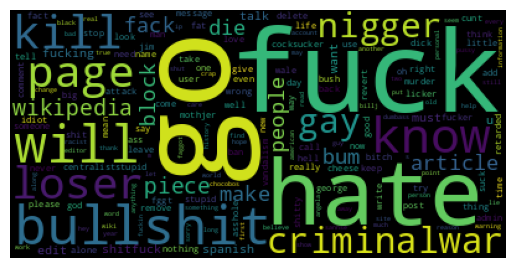

In [22]:
cloud = WordCloud(collocations = False).generate(toxic_text)
plt.imshow(cloud)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

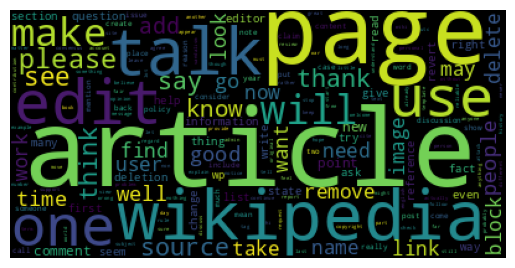

In [23]:
cloud = WordCloud(collocations = False).generate(non_toxic_text)
plt.imshow(cloud)
plt.axis('off')

Подготовка признаков с помощью TF-IDF

Разбиение на выборки

In [24]:
train, test = train_test_split(data, test_size=0.2, stratify=data['toxic'], random_state=12345)

In [25]:
corpus_train = train['lemm_text']
tf_idf_target_train = train['toxic']

corpus_test = test['lemm_text']
tf_idf_target_test = test['toxic']

In [26]:
corpus_train_tf = count_tf_idf.fit_transform(corpus_train)
print(corpus_train.shape)

corpus_test_tf = count_tf_idf.transform(corpus_test)
print(corpus_test.shape)

(12744,)
(3186,)


In [27]:
corpus_train.shape, tf_idf_target_train.shape

((12744,), (12744,))

In [28]:
corpus_test.shape, tf_idf_target_test.shape

((3186,), (3186,))

Выделили под тестовую выборку 20% от датасета, полученного после уменьшения выборки.

Подготовлен векторизатор для получения матрицы TF-IDF.

Подготовка признаков с помощью BERT

In [29]:
pretrained_weights = 'distilbert-base-uncased'
tokenizer = transformers.DistilBertTokenizer.from_pretrained(pretrained_weights)
model = transformers.DistilBertModel.from_pretrained(pretrained_weights)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [30]:
model = transformers.AutoModel.from_pretrained('unitary/toxic-bert')
tokenizer = transformers.AutoTokenizer.from_pretrained('unitary/toxic-bert')

config.json:   0%|          | 0.00/811 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/174 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [31]:
tokenized = data['bert_text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True))

n = max(tokenized.apply(lambda x: len(x)))
# англ. вектор с отступами
padded = np.array([i + [0]*(n - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

In [32]:
padded.shape

(15930, 512)

In [33]:
attention_mask.shape

(15930, 512)

In [34]:
batch_size = 100

embeddings = []

for i in notebook.tqdm(range(padded.shape[0] // batch_size + 1)):

    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]).to(device)

    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]).to(device)

    with torch.no_grad():
        model.to(device)
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)

    embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())

    del batch
    del attention_mask_batch
    del batch_embeddings

  0%|          | 0/160 [00:00<?, ?it/s]

In [35]:
bert_features = np.concatenate(embeddings)
bert_features.shape

(15930, 768)

In [36]:
bert_target = data['toxic']
bert_target.shape

(15930,)

In [37]:
bert_features_train, bert_features_test, bert_target_train, bert_target_test = train_test_split(bert_features, bert_target, test_size=0.2, random_state=12345)

In [38]:
bert_features_train.shape, bert_target_train.shape

((12744, 768), (12744,))

In [39]:
bert_features_test.shape, bert_target_test.shape

((3186, 768), (3186,))

Для готового очищенного и лемматизированного текста применили модель DistilBertModel.

Выделили тестовую выборку в 20%.

## Обучение

In [40]:
metrics = pd.DataFrame(columns = ['nlp_type', 'model_type', 'depth', 'n_estimators', 'f1_score', 'best_model'])

In [41]:
MIN_DEPTH = 10
MAX_DEPTH = 20
MAX_DEPTH_TREE = 30
CV = 4
MIN_EST = 1
MAX_EST = 50
N_ITER = 4

DISTRIBUTIONS_FOREST = {'max_depth':range(MIN_DEPTH, MAX_DEPTH + 1, 5), 'n_estimators':range(MIN_EST,MAX_EST + 1, 10)}
DISTRIBUTIONS_TREE = {'max_depth':range(1, MAX_DEPTH_TREE + 1, 5)}


In [42]:
def get_best_params(model, features_train, target_train, distributions=None, verbose=None):

    if distributions==None:
        distributions = DISTRIBUTIONS_FOREST

    grid = RandomizedSearchCV(model, distributions, cv = CV, scoring = 'f1', n_iter=N_ITER,
                              n_jobs = -1, random_state=12345)

    if verbose==None:
        grid.fit(features_train, target_train)
    else:
        grid.fit(features_train, target_train, verbose=verbose)

    return grid.best_estimator_, round(grid.best_score_, 3)

TF-IDF

Логистическая регрессия

In [43]:
%%time
model = LogisticRegression(random_state=12345, solver='liblinear')
tf_idf_pipeline = make_pipeline(count_tf_idf, model)

scores = cross_val_score(tf_idf_pipeline, corpus_train, tf_idf_target_train, scoring='f1', cv=CV)
metrics.loc[len(metrics.index)] = ['TF-IDF', 'LogisticRegression', None, None, round(pd.Series(scores).mean(), 3), tf_idf_pipeline]

CPU times: user 8.11 s, sys: 831 ms, total: 8.94 s
Wall time: 8.21 s


Дерево решений

In [44]:
%%time
model = DecisionTreeClassifier(random_state=12345)
tf_idf_pipeline = Pipeline([
      ('count_tf_idf', count_tf_idf),
      ('tree',model)
  ])

pipeline_distributions = {'tree__' + key: DISTRIBUTIONS_TREE[key] for key in DISTRIBUTIONS_TREE}

best_model, best_score = get_best_params(tf_idf_pipeline, corpus_train, tf_idf_target_train, pipeline_distributions)
metrics.loc[len(metrics.index)] = ['TF-IDF', 'DecisionTreeClassifier', best_model['tree'].max_depth, None, best_score, best_model]

CPU times: user 7.32 s, sys: 266 ms, total: 7.59 s
Wall time: 56.4 s


Случайный лес

In [45]:
%%time

model = RandomForestClassifier(random_state=12345)
tf_idf_pipeline = Pipeline([
      ('count_tf_idf', count_tf_idf),
      ('forest',model)
  ])

pipeline_distributions = {'forest__' + key: DISTRIBUTIONS_FOREST[key] for key in DISTRIBUTIONS_FOREST}

best_model, best_score = get_best_params(tf_idf_pipeline, corpus_train, tf_idf_target_train, pipeline_distributions)
metrics.loc[len(metrics.index)] = ['TF-IDF', 'RandomForestClassifier', best_model['forest'].max_depth,
                                   best_model['forest'].n_estimators, best_score, best_model]

CPU times: user 2.98 s, sys: 79.3 ms, total: 3.06 s
Wall time: 27.9 s


BERT

Логистическая регрессия

In [46]:
%%time
model = LogisticRegression(random_state=12345, solver='liblinear')
scores = cross_val_score(model, bert_features_train, bert_target_train, scoring='f1', cv=CV)
metrics.loc[len(metrics.index)] = ['BERT', 'LogisticRegression', None, None, round(pd.Series(scores).mean(), 3), model]

CPU times: user 15 s, sys: 527 ms, total: 15.5 s
Wall time: 15.2 s


Случайный лес

In [47]:
%%time
model = RandomForestClassifier(random_state=12345)
best_model, best_score = get_best_params(model, bert_features_train, bert_target_train)
metrics.loc[len(metrics.index)] = ['BERT', 'RandomForestClassifier', best_model.max_depth, best_model.n_estimators, best_score,
                                   best_model]

CPU times: user 10.9 s, sys: 154 ms, total: 11.1 s
Wall time: 57.7 s


metrics = metrics.sort_values('f1_score', ascending=False).reset_index(drop=True)
best_model = metrics.loc[0, 'best_model']
metrics = metrics.drop('best_model', axis=1)
metrics

In [48]:
%%time
model = DecisionTreeClassifier(random_state=12345)
best_model, best_score = get_best_params(model, bert_features_train, bert_target_train, DISTRIBUTIONS_TREE)
metrics.loc[len(metrics.index)] = ['BERT', 'DecisionTreeClassifier', best_model.max_depth, None, best_score, best_model]


CPU times: user 2.1 s, sys: 145 ms, total: 2.25 s
Wall time: 2min 5s


In [49]:
metrics = metrics.sort_values('f1_score', ascending=False).reset_index(drop=True)
best_model = metrics.loc[0, 'best_model']
metrics = metrics.drop('best_model', axis=1)
metrics

,nlp_type,model_type,depth,n_estimators,f1_score
0,BERT,RandomForestClassifier,15,31,0.914
1,BERT,LogisticRegression,None,None,0.908
2,BERT,DecisionTreeClassifier,1,None,0.901
3,TF-IDF,DecisionTreeClassifier,26,None,0.645
4,TF-IDF,LogisticRegression,None,None,0.396
5,TF-IDF,RandomForestClassifier,10,1,0.039


In [50]:
best_model

RandomForestClassifier(max_depth=15, n_estimators=31, random_state=12345)

In [51]:
if metrics.loc[0, 'nlp_type'] == 'BERT':
  best_model.fit(bert_features_train, bert_target_train)
  predictions = best_model.predict(bert_features_test)
  print(f1_score(bert_target_test, predictions))
else:
  best_model.fit(corpus_train, tf_idf_target_train)
  predictions = best_model.predict(corpus_test)
  print(f1_score(tf_idf_target_test, predictions))

0.9285714285714286


0.9027585144089998

## Выводы

Загрузка и подготовка данных

Данные были успешно загружены. С целью сокращения времени обучения было извлечено 10% случайных строк из всех данных, с сохранением баланса целевого класса.

Был проведен частотный анализ текстов и сделано облако слов. Видим, что часто использеумые слова различаются в токсичных и не токсичных комментариях.

Обучение

Была использована модель - distilbert.
Лучшая - модель BERT RandomForest, c f1 - 0.914
Тестирование

Лучшая модель была протестирована на тестовой выборке. Показатель F1, равный 0.928.

# Вывод

Лучшая модель - RandomForest для признаков, подготовленных с помощью BERT. Она дает на тестовой выборке F1-меру, равную 0.928